In [1]:
from keras.models   import Model, Sequential, load_model
from keras.layers   import Input, Dense, Flatten, Dropout, Conv2D, MaxPooling2D, UpSampling2D, Reshape
from keras.utils    import plot_model
from keras.datasets import mnist

from keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing     import OneHotEncoder

import h5py

import numpy  as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import Image 

%matplotlib inline

Using TensorFlow backend.
/mnt/gpfs/Users/chenhe/bin/anaconda3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


# CNN model for MNIST data 

## Load data

In [2]:
(x_train_orig, y_train_orig), (x_test_orig, y_test_orig) = mnist.load_data()

x_train = np.reshape( 
    (x_train_orig.astype('float32') / 255.), 
    (len(x_train_orig), x_train_orig.shape[1], x_train_orig.shape[2], 1) 
)

x_test  = np.reshape( 
    (x_test_orig.astype('float32')  / 255.), 
    (len(x_test_orig),  x_test_orig.shape[1],  x_test_orig.shape[2],  1) 
)

y_train = OneHotEncoder(sparse=False,categories='auto').fit_transform(y_train_orig.reshape(-1, 1))
y_test  = OneHotEncoder(sparse=False,categories='auto').fit_transform(y_test_orig.reshape(-1, 1))

## CNN Model

```python
model = Sequential()
model.add( Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(28,28,1)) )
model.add( MaxPooling2D() )
model.add( Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same') )
model.add( MaxPooling2D() )
model.add( Dropout(0.25) )
model.add( Flatten() )
model.add( Dense(512, activation='relu')
model.add( Dense(128, activation='relu')
model.add( Dense(32,  activation='relu')
model.add( Dense(10,  activation='softmax') )
```

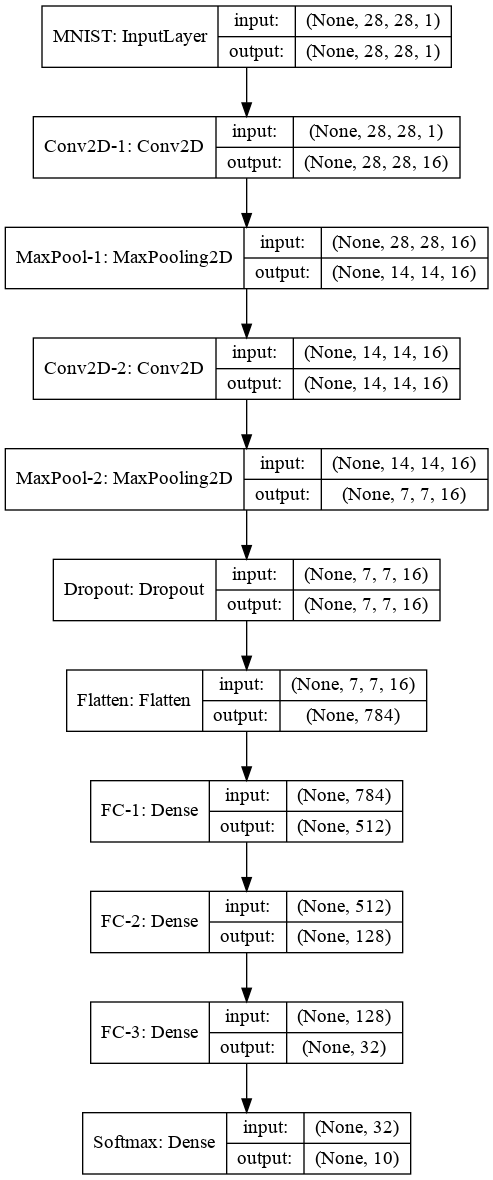

In [3]:
mnist_inputs = Input(name='MNIST', shape=(28,28,1,))

x1 = mnist_inputs
x1 = Conv2D( 16, kernel_size=(3, 3),
    activation='relu', padding='same', name='Conv2D-1' )(x1)
x1 = MaxPooling2D(                     name='MaxPool-1')(x1)
x1 = Conv2D( 16, kernel_size=(3, 3),
    activation='relu', padding='same', name='Conv2D-2' )(x1)
x1 = MaxPooling2D(                     name='MaxPool-2')(x1)
x1 = Dropout(0.25,                     name='Dropout'  )(x1)
x1 = Flatten(                          name='Flatten'  )(x1)
x1 = Dense(512, activation='relu',     name='FC-1'     )(x1)
x1 = Dense(128, activation='relu',     name='FC-2'     )(x1)
x1 = Dense(32,  activation='relu',     name='FC-3'     )(x1)
x1 = Dense(10,  activation='softmax',  name='Softmax'  )(x1)
mnist_pred = x1

mnist_cnn_model = Model(inputs=mnist_inputs, outputs=mnist_pred)

plot_model(mnist_cnn_model, show_shapes=True, to_file='mnist_cnn_model.png')
Image(filename='mnist_cnn_model.png')


## Train & validation

In [4]:
mnist_cnn_model.compile(
    loss='categorical_crossentropy',
    optimizer='adadelta',
    metrics=['accuracy']
)

history = mnist_cnn_model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=10,
    batch_size=128,
    shuffle=True, 
    verbose=2,
)

print ()
score = mnist_cnn_model.evaluate(x_test, y_test, verbose=0)
print('Test loss:',     score[0])
print('Test accuracy:', score[1])

mnist_cnn_model.save('mnist_cnn_model.h5')

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
 - 8s - loss: 0.2999 - acc: 0.9031 - val_loss: 0.0725 - val_acc: 0.9775
Epoch 2/10
 - 8s - loss: 0.0761 - acc: 0.9759 - val_loss: 0.0399 - val_acc: 0.9869
Epoch 3/10
 - 8s - loss: 0.0562 - acc: 0.9819 - val_loss: 0.0327 - val_acc: 0.9895
Epoch 4/10
 - 8s - loss: 0.0449 - acc: 0.9855 - val_loss: 0.0345 - val_acc: 0.9891
Epoch 5/10
 - 8s - loss: 0.0385 - acc: 0.9880 - val_loss: 0.0313 - val_acc: 0.9894
Epoch 6/10
 - 8s - loss: 0.0329 - acc: 0.9895 - val_loss: 0.0250 - val_acc: 0.9913
Epoch 7/10
 - 8s - loss: 0.0297 - acc: 0.9901 - val_loss: 0.0253 - val_acc: 0.9925
Epoch 8/10
 - 8s - loss: 0.0277 - acc: 0.9909 - val_loss: 0.0281 - val_acc: 0.9910
Epoch 9/10
 - 8s - loss: 0.0249 - acc: 0.9919 - val_loss: 0.0269 - val_acc: 0.9908
Epoch 10/10
 - 8s - loss: 0.0215 - acc: 0.9933 - val_loss: 0.0263 - val_acc: 0.9915

Test loss: 0.02625610151426663
Test accuracy: 0.9915


In [5]:
# data1 = []
# data2 = []

# pred = np.argmax(model.predict(x_test), axis=1)

# for index in np.where(pred != y_test_orig)[0]:
#     data1.append(y_test_orig[index])
#     data2.append(pred[index])


# data1 = pd.Series(data1).value_counts().sort_index().reset_index()
# data2 = pd.Series(data2).value_counts().sort_index().reset_index().set_index('index').reindex(data1.index).fillna(0).reset_index()

# sns.barplot(data=data1,x='index',y=0)
# plt.show()
# sns.barplot(data=data2,x='index',y=0)

# plt.show()

In [6]:
# n = 0
# for index in np.where(np.argmax(mnist_cnn_model.predict(x_test), axis=1) != y_test_orig)[0]:
#     plt.imshow(x_test_orig[index])
#     print (str(index)+": y = " + str(y_test_orig[index]) + ', ' + str(np.argmax(mnist_cnn_model.predict(x_test), axis=1)[index]) )
#     plt.show()

#     n += 1
#     if n>5:
#         break

---
---
---

# CNN model for N-signs
- Datasets: https://www.floydhub.com/deeplearningai/datasets/signs
- Github: https://github.com/mesolmaz/HandSigns_CNN


***Warnings***

> Small dataset! Work well in CNN, but not work well in Autoencoder

## Load data

In [7]:
f1 = h5py.File("train_signs.h5", "r")
f2 = h5py.File("test_signs.h5",  "r")

# Loading the data (signs)
X_train_orig = np.array(f1['train_set_x'])
Y_train_orig = np.array(f1['train_set_y'])
X_test_orig  = np.array(f2['test_set_x'])
Y_test_orig  = np.array(f2['test_set_y'])

# print ("Training Data Feature Size = " + str(X_train_orig.shape))
# print ("Training Data Class Size = " + str(Y_train_orig.shape))
# print ("Test Data Feature Size = " + str(X_test_orig.shape))
# print ("Test Data Class Size = " + str(Y_test_orig.shape))

X_train = (X_train_orig / 255).astype('float32')
X_test  = (X_test_orig  / 255).astype('float32')

test_datagen  = ImageDataGenerator( rescale=1./255, )
train_datagen = ImageDataGenerator( rescale=1./255,
    width_shift_range  = 0.15,
    height_shift_range = 0.15,
    shear_range        = 0.3,
    zoom_range         = 0.1,
    rotation_range     = 30,
    horizontal_flip    = True,
    vertical_flip      = False,
    fill_mode          = 'nearest',
)

train_datagen.fit(X_train_orig)
test_datagen.fit(X_test_orig)


Y_train = OneHotEncoder(sparse=False,categories='auto').fit_transform(Y_train_orig.reshape(-1, 1))
Y_test  = OneHotEncoder(sparse=False,categories='auto').fit_transform(Y_test_orig.reshape(-1, 1))

# (Y_train.argmax(axis=1) == Y_train_orig).all()

# print ("number of training examples = " + str(X_train.shape[0]))
# print ("number of test examples = " + str(X_test.shape[0]))
# print ("X_train shape: " + str(X_train.shape))
# print ("Y_train shape: " + str(Y_train.shape))
# print ("X_test shape: " + str(X_test.shape))
# print ("Y_test shape: " + str(Y_test.shape))

# # Example of a picture
# index = 1
# plt.imshow(X_train_orig[index])
# print ("y = " + str(Y_train_orig[index]))

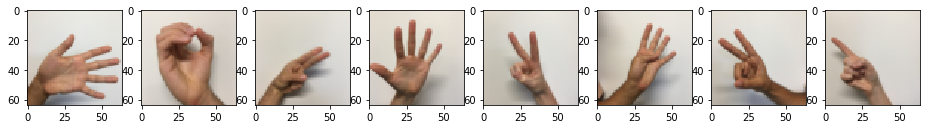

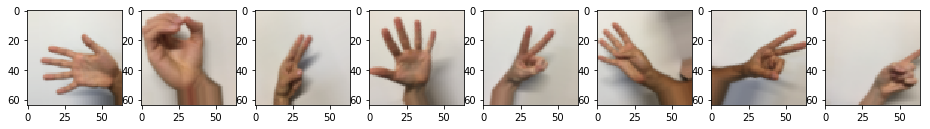

In [8]:
data_iter = train_datagen.flow(X_train_orig, batch_size=8, shuffle=False)

x_batch = data_iter.next()

plt.figure(figsize=(16,8))
for i in range(8):
    plt.subplot(1,8,i+1)
    plt.imshow(X_train_orig[i].reshape(64,64,3), cmap='gray')
plt.show()

plt.figure(figsize=(16,8))
for i in range(8):
    plt.subplot(1,8,i+1)
    plt.imshow(x_batch[i].reshape(64,64,3), cmap='gray')
plt.show()


## CNN Model


```python
model = Sequential()
model.add( Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(64,64,3)) )
model.add( MaxPooling2D() )
model.add( Dropout(0.2) )
model.add( Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same',) )
model.add( MaxPooling2D() )
model.add( Dropout(0.2) )
model.add( Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same',) )
model.add( MaxPooling2D() )
model.add( Dropout(0.2) )
model.add( Flatten() )
model.add( Dense(512, activation='relu') )
model.add( Dense(256, activation='relu') )
model.add( Dense(128, activation='relu') )
model.add( Dense(6,   activation='softmax') )
```

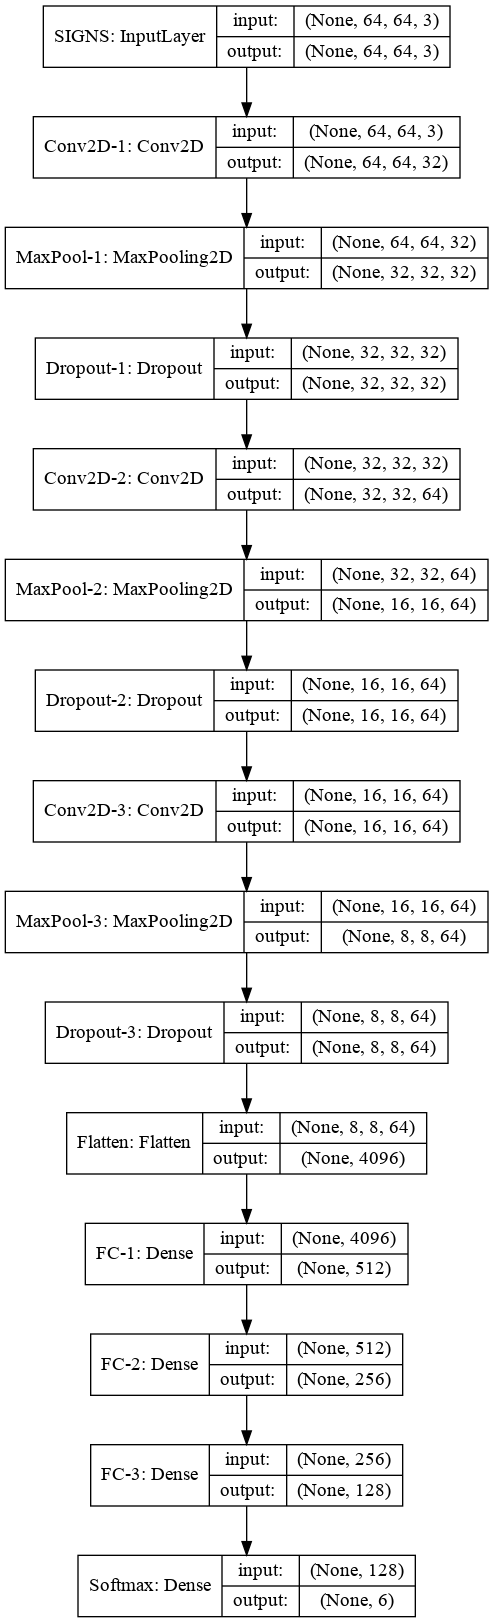

In [9]:
signs_inputs = Input(name='SIGNS', shape=(64,64,3,))

x2 = signs_inputs
x2 = Conv2D( 32, kernel_size=(3, 3),  
    activation='relu', padding='same', name='Conv2D-1' )(x2)
x2 = MaxPooling2D(                     name='MaxPool-1')(x2)
x2 = Dropout(0.2,                      name='Dropout-1')(x2)
x2 = Conv2D( 64, kernel_size=(3, 3),  
    activation='relu', padding='same', name='Conv2D-2' )(x2)
x2 = MaxPooling2D(                     name='MaxPool-2')(x2)
x2 = Dropout(0.2,                      name='Dropout-2')(x2)
x2 = Conv2D( 64, kernel_size=(3, 3),  
    activation='relu', padding='same', name='Conv2D-3' )(x2)
x2 = MaxPooling2D(                     name='MaxPool-3')(x2)
x2 = Dropout(0.2,                      name='Dropout-3')(x2)
x2 = Flatten(                          name='Flatten'  )(x2)
x2 = Dense(512, activation='relu',     name='FC-1'     )(x2)
# x2 = Dropout(0.2,                      name='Dropout-4')(x2)
x2 = Dense(256, activation='relu',     name='FC-2'     )(x2)
x2 = Dense(128, activation='relu',     name='FC-3'     )(x2)
x2 = Dense(6,   activation='softmax',  name='Softmax'  )(x2)
signs_pred = x2

signs_cnn_model = Model(inputs=signs_inputs, outputs=signs_pred)

plot_model(signs_cnn_model, show_shapes=True, to_file='signs_cnn_model.png')
Image(filename='signs_cnn_model.png')

In [10]:
signs_cnn_model.compile(
    loss='categorical_crossentropy',
    optimizer='adadelta',
    metrics=['accuracy']
)

history = signs_cnn_model.fit_generator(
    train_datagen.flow(X_train_orig, Y_train, batch_size=32, shuffle=True),
    validation_data=(X_test, Y_test),
    epochs=50,
    use_multiprocessing=True,
    verbose=2,
)

print ()
score = signs_cnn_model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:',     score[0])
print('Test accuracy:', score[1])

signs_cnn_model.save('signs_cnn_model.h5')

Epoch 1/50
 - 4s - loss: 1.8036 - acc: 0.1630 - val_loss: 1.7918 - val_acc: 0.1667
Epoch 2/50
 - 3s - loss: 1.7946 - acc: 0.1749 - val_loss: 1.7919 - val_acc: 0.1667
Epoch 3/50
 - 4s - loss: 1.7944 - acc: 0.1651 - val_loss: 1.7916 - val_acc: 0.1667
Epoch 4/50
 - 3s - loss: 1.7937 - acc: 0.1575 - val_loss: 1.7917 - val_acc: 0.1667
Epoch 5/50
 - 4s - loss: 1.7932 - acc: 0.1599 - val_loss: 1.7906 - val_acc: 0.1667
Epoch 6/50
 - 4s - loss: 1.7909 - acc: 0.1734 - val_loss: 1.7899 - val_acc: 0.3333
Epoch 7/50
 - 4s - loss: 1.7886 - acc: 0.1902 - val_loss: 1.7689 - val_acc: 0.1667
Epoch 8/50
 - 4s - loss: 1.7769 - acc: 0.2181 - val_loss: 1.8268 - val_acc: 0.2667
Epoch 9/50
 - 4s - loss: 1.7703 - acc: 0.2240 - val_loss: 1.6693 - val_acc: 0.3250
Epoch 10/50
 - 4s - loss: 1.7287 - acc: 0.2469 - val_loss: 1.6417 - val_acc: 0.4250
Epoch 11/50
 - 3s - loss: 1.6532 - acc: 0.3097 - val_loss: 1.6737 - val_acc: 0.2833
Epoch 12/50
 - 4s - loss: 1.6504 - acc: 0.3015 - val_loss: 1.4308 - val_acc: 0.4583
E

25: y = 5, 4


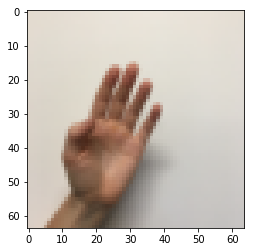

27: y = 2, 1


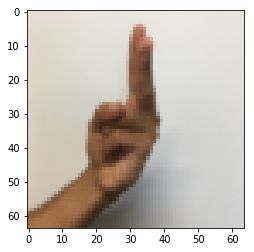

60: y = 5, 4


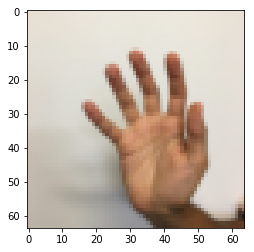

61: y = 5, 4


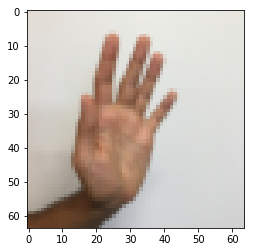

93: y = 5, 4


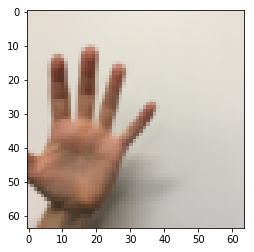

In [11]:
# # Plot training & validation accuracy values
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
# plt.title('Model accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')
# plt.show()

# # Plot training & validation loss values
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Model loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper right')
# plt.show()

n = 0
for index in np.where(np.argmax(signs_cnn_model.predict(X_test), axis=1) != Y_test_orig)[0]:
    plt.imshow(X_test_orig[index])
    print (str(index)+": y = " + str(Y_test_orig[index]) + ', ' + str(np.argmax(signs_cnn_model.predict(X_test), axis=1)[index]) )
    plt.show()

    n += 1
    if n>5:
        break

---
---
---

# Building Autoencoders in Keras


### [Code & Text Source](https://blog.keras.io/building-autoencoders-in-keras.html)

## What are autoencoders?

![img](https://blog.keras.io/img/ae/autoencoder_schema.jpg)

"Autoencoding" is a data compression algorithm where the compression and decompression functions are:
1. data-specific
> they will only be able to compress data similar to what they have been trained on
2. lossy
3. learned automatically from examples rather than engineered by a human.

Additionally, in almost all contexts where the term "autoencoder" is used, the compression and decompression functions are implemented with neural networks.

---

To build an autoencoder, you need three things: 
- an encoding function
- a decoding function
- a distance function between the amount of information loss between the compressed representation of your data and the decompressed representation (i.e. a "loss" function)

## What are autoencoders good for?

- data denoising
- dimensionality reduction for data visualization

---

# Autoencoder for MNIST data 

- The CNN model


In [12]:
mnist_cnn_model = load_model('mnist_cnn_model.h5')
mnist_encoder = Model(inputs=mnist_cnn_model.input, outputs=mnist_cnn_model.get_layer('FC-3').output)
mnist_encoder.trainable = False
mnist_encoder.compile(optimizer='adadelta', loss='mse')

In [13]:
mnist_encoder.trainable_weights

[]

In [14]:
# mnist_encoder.summary()

In [15]:
mnist_z = mnist_encoder.output
x1 = Dense(128, activation='relu',         name='dFC-1'     )(mnist_z) 
x1 = Dense(512, activation='relu',         name='dFC-2'     )(x1)
x1 = Dense(784, activation='relu',         name='dFC-3'     )(x1)
x1 = Reshape((7, 7, 16),                   name='Reshape'   )(x1)
x1 = Conv2D( 16, kernel_size=(3, 3), 
    activation='relu',     padding='same', name='deConv2D-1')(x1)
x1 = UpSampling2D(                         name='UpSample-1')(x1)
x1 = Conv2D( 16, kernel_size=(3, 3), 
    activation='relu',     padding='same', name='deConv2D-2')(x1)
x1 = UpSampling2D(                         name='UpSample-2')(x1)
x1 = Conv2D( 1, kernel_size=(3, 3), 
    activation='sigmoid',  padding='same', name='deConv2D-3')(x1)
mnist_decoded = x1

In [16]:
mnist_autoencoder = Model(inputs=mnist_cnn_model.input, outputs=mnist_decoded)

flag = 0
for layer in mnist_autoencoder.layers:
    if flag == 0:
        if layer.name != 'dFC-1':
            layer.trainable = False
        else:
            flag = 1
    else:
        pass

mnist_autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [17]:
# mnist_autoencoder.summary()
# plot_model(mnist_autoencoder, show_shapes=True, to_file='mnist_autoencoder.png')
# Image(filename='mnist_autoencoder.png')

In [18]:
mnist_autoencoder.fit(
    x_train, x_train,
    epochs=10,
    batch_size=128,
    shuffle=True,
    verbose=2,
    validation_data=(x_test, x_test)
)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
 - 21s - loss: 0.2160 - val_loss: 0.1876
Epoch 2/10
 - 21s - loss: 0.1848 - val_loss: 0.1737
Epoch 3/10
 - 21s - loss: 0.1743 - val_loss: 0.1630
Epoch 4/10
 - 20s - loss: 0.1686 - val_loss: 0.1587
Epoch 5/10
 - 21s - loss: 0.1648 - val_loss: 0.1595
Epoch 6/10
 - 21s - loss: 0.1625 - val_loss: 0.1556
Epoch 7/10
 - 21s - loss: 0.1606 - val_loss: 0.1532
Epoch 8/10
 - 21s - loss: 0.1588 - val_loss: 0.1507
Epoch 9/10
 - 20s - loss: 0.1577 - val_loss: 0.1513
Epoch 10/10
 - 21s - loss: 0.1567 - val_loss: 0.1510


In [19]:
mnist_Z_input = Input(name='MNIST-Z', shape=(32, ))

x1 = mnist_autoencoder.get_layer('dFC-1')(mnist_Z_input)

flag = 0
for layer in mnist_autoencoder.layers:
    if flag == 0:
        if layer.name != 'dFC-1':
            pass
        else:
            flag = 1
    else:
        x1 = layer(x1)

mnist_decoder = Model(inputs=mnist_Z_input, outputs=x1)

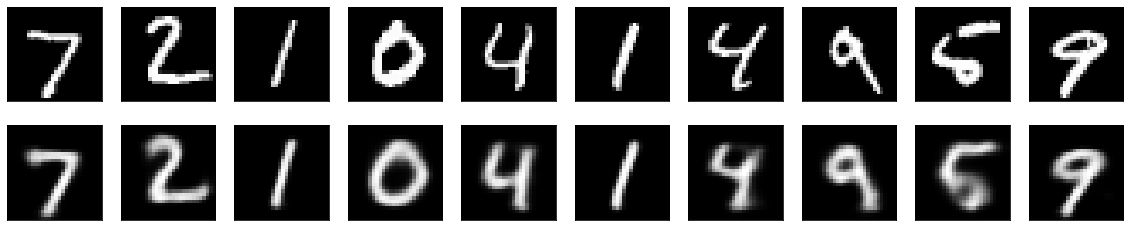

In [20]:
encoded_imgs = mnist_encoder.predict(x_test)
decoded_imgs = mnist_decoder.predict(encoded_imgs)
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

---

# Autoencoder for N-signs data 

- The CNN model



In [21]:
signs_cnn_model = load_model('signs_cnn_model.h5')
signs_encoder = Model(inputs=signs_cnn_model.input, outputs=signs_cnn_model.get_layer('FC-3').output)
signs_encoder.trainable = False
signs_encoder.compile(optimizer='adadelta', loss='mse')

In [22]:
signs_encoder.trainable_weights

[]

In [23]:
signs_encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
SIGNS (InputLayer)           (None, 64, 64, 3)         0         
_________________________________________________________________
Conv2D-1 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
MaxPool-1 (MaxPooling2D)     (None, 32, 32, 32)        0         
_________________________________________________________________
Dropout-1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
Conv2D-2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
MaxPool-2 (MaxPooling2D)     (None, 16, 16, 64)        0         
_________________________________________________________________
Dropout-2 (Dropout)          (None, 16, 16, 64)        0         
__________

In [24]:
signs_z = signs_encoder.output
x1 = Dense(256,  activation='relu',       name='dFC-1'     )(signs_z) 
x1 = Dense(512,  activation='relu',       name='dFC-2'     )(x1)
x1 = Dense(4096, activation='relu',       name='dFC-3'     )(x1)
x1 = Reshape((8, 8, 64),                  name='Reshape'   )(x1)
x1 = Conv2D( 64, kernel_size=(3, 3), 
    activation='relu',    padding='same', name='deConv2D-1')(x1)
x1 = UpSampling2D(                        name='UpSample-1')(x1)
x1 = Conv2D( 64, kernel_size=(3, 3), 
    activation='relu',    padding='same', name='deConv2D-2')(x1)
x1 = UpSampling2D(                        name='UpSample-2')(x1)
x1 = Conv2D( 32, kernel_size=(3, 3), 
    activation='relu',    padding='same', name='deConv2D-3')(x1)
x1 = UpSampling2D(                        name='UpSample-3')(x1)
x1 = Conv2D( 3, kernel_size=(3, 3),  
    activation='sigmoid', padding='same', name='deConv2D-4')(x1)
signs_decoded = x1

In [25]:
signs_autoencoder = Model(inputs=signs_cnn_model.input, outputs=signs_decoded)

flag = 0
for layer in signs_autoencoder.layers:
    if flag == 0:
        if layer.name != 'dFC-1':
            layer.trainable = False
        else:
            flag = 1
    else:
        pass

signs_autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
# signs_autoencoder.compile(optimizer='adadelta', loss='mse')

In [26]:
# from keras.callbacks import TensorBoard

In [27]:
def fixed_generator(generator):
    for batch in generator:
        yield (batch, batch)
        
history = signs_autoencoder.fit_generator(
#     train_datagen.flow(X_train_orig, batch_size=32, shuffle=True),
    fixed_generator( train_datagen.flow(X_train_orig, batch_size=32, shuffle=True) ),
    validation_data=(X_test, X_test),
    epochs=10,
    verbose=2,
    steps_per_epoch=100,
    use_multiprocessing=True,
#     callbacks=[TensorBoard(log_dir='./log')]
)

Epoch 1/10
 - 19s - loss: 0.5799 - val_loss: 0.5594
Epoch 2/10
 - 18s - loss: 0.5632 - val_loss: 0.5523
Epoch 3/10
 - 18s - loss: 0.5583 - val_loss: 0.5502
Epoch 4/10
 - 17s - loss: 0.5553 - val_loss: 0.5538
Epoch 5/10
 - 17s - loss: 0.5524 - val_loss: 0.5475
Epoch 6/10
 - 17s - loss: 0.5504 - val_loss: 0.5425
Epoch 7/10
 - 18s - loss: 0.5487 - val_loss: 0.5404
Epoch 8/10
 - 18s - loss: 0.5485 - val_loss: 0.5448
Epoch 9/10
 - 17s - loss: 0.5473 - val_loss: 0.5408
Epoch 10/10
 - 17s - loss: 0.5453 - val_loss: 0.5397


In [28]:
# signs_autoencoder.fit(
#     X_train, X_train,
#     epochs=20,
#     batch_size=32,
#     shuffle=True,
#     verbose=2,
#     validation_data=(X_test, X_test)
# )

In [29]:
# signs_Z_input = Input(name='SIGNS-Z', shape=(64, ))
signs_Z_input = Input(name='SIGNS-Z', shape=(128, ))

x1 = signs_autoencoder.get_layer('dFC-1')(signs_Z_input)

flag = 0
for layer in signs_autoencoder.layers:
    if flag == 0:
        if layer.name != 'dFC-1':
            pass
        else:
            flag = 1
    else:
        x1 = layer(x1)

signs_decoder = Model(inputs=signs_Z_input, outputs=x1)

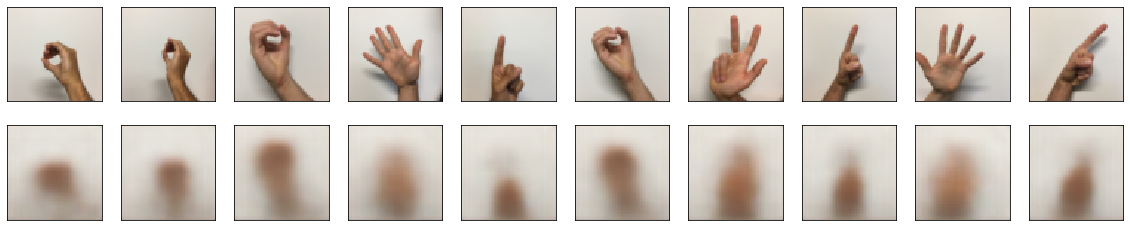

In [30]:
encoded_imgs = signs_encoder.predict(X_test)
decoded_imgs = signs_decoder.predict(encoded_imgs)
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [31]:
# plot_model(mnist_autoencoder, show_shapes=True, to_file='mnist_autoencoder.png')
# plot_model(mnist_encoder,     show_shapes=True, to_file='mnist_encoder.png')
# plot_model(mnist_decoder,     show_shapes=True, to_file='mnist_decoder.png')

# mnist_autoencoder.summary()
# mnist_encoder.summary()
# mnist_decoder.summary()

In [32]:

# input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

# x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
# x = MaxPooling2D((2, 2), padding='same')(x)
# x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
# x = MaxPooling2D((2, 2), padding='same')(x)
# x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
# encoded = MaxPooling2D((2, 2), padding='same')(x)

# # at this point the representation is (4, 4, 8) i.e. 128-dimensional

# x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
# x = UpSampling2D((2, 2))(x)
# x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
# x = UpSampling2D((2, 2))(x)
# x = Conv2D(16, (3, 3), activation='relu')(x)
# x = UpSampling2D((2, 2))(x)
# decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# autoencoder = Model(input_img, decoded)
# autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

---
---
---